# Load training data

In [1]:
import csv
import cv2
import numpy as np

lines = []
with open('data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []
for line in lines:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/data/IMG/' + filename
    image = cv2.imread(current_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    
X_train = np.array(images)
y_train = np.array(measurements)

# Create network

In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)

model.save('model.h5')

Using TensorFlow backend.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 6428 samples, validate on 1608 samples
Epoch 1/2
6428/6428 [==============================] - 8s 1ms/step - loss: 2.3552 - val_loss: 0.2779 - ETA: 0s - los
Epoch 2/2
6428/6428 [==============================] - 8s 1ms/step - loss: 0.5661 - val_loss: 0.8492


In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda

conv_base = VGG16(include_top=False, input_shape=(160,320,3))

model = Sequential()
model.add(conv_base)
#model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=1)

model.save('model.h5')

Train on 6428 samples, validate on 1608 samples
Epoch 1/1
6428/6428 [==============================] - 1012s - loss: 1339.4374 - val_loss: 0.0144


# Generator

In [3]:
import os
import csv

samples = []
with open('data/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn
from random import shuffle, random


def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:                        
                name = 'data/data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                #center_image = cv2.resize(center_image, (200, 66), cv2.INTER_AREA)
                center_angle = float(batch_sample[3])
                
                if random() >= .5 and abs(float(batch_sample[3])) > 0.1:
                    center_image = cv2.flip(center_image, 1)
                    center_angle = -float(batch_sample[3])
                    
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Nvidia Network

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Dropout, Cropping2D
from keras.optimizers import Adam

model = Sequential()
#normalize
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))

model.add(Convolution2D(24,
                        5, 5,
                        border_mode='valid',
                        subsample=(2,2),
                        activation='relu'))
#model.add(Dropout(0.4))

model.add(Convolution2D(36,
                        5, 5,
                        border_mode='valid',
                        subsample=(2,2),
                        activation='relu'))
#model.add(Dropout(0.7))

model.add(Convolution2D(48,
                        5, 5,
                        border_mode='valid',
                        subsample=(2,2),
                        activation='relu'))
#model.add(Dropout(0.6))

model.add(Convolution2D(64,
                        3, 3,
                        border_mode='valid',
                        activation='relu'))
#model.add(Dropout(0.5))

model.add(Convolution2D(64,
                        3, 3,
                        border_mode='valid',
                        activation='relu'))
#model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1164, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(1))


train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

adam = Adam(lr=0.001)
model.compile(loss='mse', optimizer=adam)
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2)
history_object = model.fit_generator(train_generator,
                    samples_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=5, verbose=1)

model.save('model.h5')

Using TensorFlow backend.


Epoch 1/5
6428/6428 [==============================] - 112s - loss: 0.0117 - val_loss: 0.0103
Epoch 2/5
6428/6428 [==============================] - 110s - loss: 0.0088 - val_loss: 0.0088
Epoch 3/5
6428/6428 [==============================] - 110s - loss: 0.0083 - val_loss: 0.0086
Epoch 4/5
6428/6428 [==============================] - 110s - loss: 0.0079 - val_loss: 0.0078
Epoch 5/5
6428/6428 [==============================] - 110s - loss: 0.0075 - val_loss: 0.0082


In [4]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

In [6]:
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


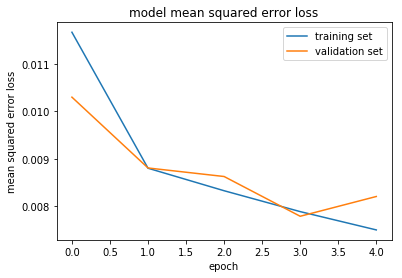

In [6]:
from keras.models import Model
import matplotlib.pyplot as plt

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Epoch 1/5
6428/6428 [==============================] - 113s - loss: 0.0073 - val_loss: 0.0069
Epoch 2/5
6428/6428 [==============================] - 111s - loss: 0.0076 - val_loss: 0.0074
Epoch 3/5
6428/6428 [==============================] - 112s - loss: 0.0074 - val_loss: 0.0080
Epoch 4/5
6428/6428 [==============================] - 112s - loss: 0.0068 - val_loss: 0.0085
Epoch 5/5
6428/6428 [==============================] - 111s - loss: 0.0066 - val_loss: 0.0062
dict_keys(['val_loss', 'loss'])


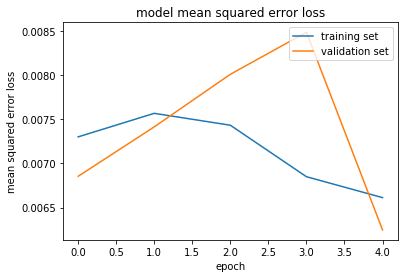

In [4]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()